Merge open satellite data after cleaning. Write out emission statistics per country for the cmm data tool  

Run these notebooks beforehand to standardise the data  
* eda_mars.ipynb
* eda_kayrros_methane_watch.ipynb
* eda_carbon_mapper.ipynb

* Note emissions data for all sources are included, so filter for coal
* Some platforms have duplicate data (e.g. Kayrros and MARS) - delete duplicates 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
download_date   = '11032025'
directory       = 'satellite/data/' 

In [3]:
#                       Datasets to merge have this format
#----------------------------------------------------------------------------------------------------------
# sensor, country, date, emission rate (kg/h), uncertainty (kg/h), latitude, longitude, comments, platform | 
#----------------------------------------------------------------------------------------------------------

In [4]:
mw_fname = f'Methane_Watch_asset_data_cleaned_{download_date}.csv'

mw = pd.read_csv(os.path.join(directory, 'kayrros', mw_fname)) 
mw.columns = mw.columns.str.strip() 
print(mw.columns)

Index(['sensor', 'country', 'sector', 'date', 'emission rate (kg/h)',
       'uncertainty (kg/h)', 'latitude', 'longitude', 'comments', 'platform'],
      dtype='object')


In [5]:
mars_fname = f'unep_methanedata_detected_plumes_cleaned_{download_date}.csv' 
mars = pd.read_csv(os.path.join(directory, 'mars', mars_fname))
print(mars.columns)

Index(['sensor', 'sector', 'country', 'date', 'emission rate (kg/h)',
       'uncertainty (kg/h)', 'latitude', 'longitude', 'comments', 'platform'],
      dtype='object')


In [6]:
cm_fname = f'carbon_mapper_cleaned_{download_date}.csv' 
cm = pd.read_csv(os.path.join(directory, 'carbonmapper',f'downloaded_{download_date}', cm_fname))
print(cm.columns)

Index(['sensor', 'sector', 'country', 'date', 'emission rate (kg/h)',
       'uncertainty (kg/h)', 'latitude', 'longitude', 'comments', 'platform'],
      dtype='object')


In [7]:
# merge the data 
merged_df = pd.concat([mw, mars, cm], ignore_index=True)

# filter for coal 
merged_df = merged_df[merged_df['sector'] == 'Coal']

# drop duplictes
merged_df = merged_df.drop_duplicates(subset=['latitude', 'longitude', 'date', 'emission rate (kg/h)', 'sector', 'country', 'sensor'])

In [8]:
#Addition from Bex Horner to make sure there is no duplicates during merge

df = merged_df

# Step 1: Identify duplicates based on sensor, date, lat, lon
dup_keys = ["sensor", "date", "latitude", "longitude"]

# Step 2: Keep only those groups where platform differs
df['platform_count'] = df.groupby(dup_keys)['platform'].transform('nunique')

# Step 3: Filter only rows with >1 unique platform
df_dupes = df[df['platform_count'] > 1].copy()

# Step 4: Define a helper to pick the best record from each group
def pick_best(group):
    # Prefer rows with both emission rate and uncertainty not null
    has_both = group[
        group['emission rate (kg/h)'].notna() &
        group['uncertainty (kg/h)'].notna()
    ]
    if not has_both.empty:
        return has_both.iloc[0]  # keep the first of those
    else:
        return group.iloc[0]     # otherwise keep the first in the group

# Step 5: Apply per-group selection
result_dupes = df_dupes.groupby(dup_keys, group_keys=False).apply(pick_best)

# Step 6: Combine with the rest of the data (non-duplicates)
result = pd.concat([
    df[df['platform_count'] == 1],  # unique platform
    result_dupes
], ignore_index=True)

# Step 7: Drop the helper column
result = result.drop(columns='platform_count')

result = result.sort_values(by=["country","date"])

merged_df = result

C:\Users\rebek\AppData\Local\Temp\ipykernel_30496\1799784530.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_dupes = df_dupes.groupby(dup_keys, group_keys=False).apply(pick_best)


In [9]:
# merged filename
merged_fname = f'merged_kayrros_mars_carbonmapper_{download_date}_coal.csv'

# write out a merged csv
merged_df.to_csv(os.path.join(directory, merged_fname), index=False) 

In [10]:
# Get emission statistics per country
summary_data = []

# count number of observations and get the range 
# i.e. what is data coverage in my country of interest, what countries are being monitored well?  
for country in merged_df['country'].unique():
    country_data = merged_df[merged_df['country'] == country]
    country_emissions = country_data['emission rate (kg/h)']
    
    summary_data.append({
        'country': country,
        'number observations': len(country_emissions),
        'median (kg/h)': country_emissions.median(),
        'min (kg/h)': country_emissions.min(),
        'max (kg/h)': country_emissions.max()
    })

summary_df = pd.DataFrame(summary_data)

# Sensor counts per country i.e. what facility level data is available ? 
sensor_counts_df = merged_df.pivot_table(
    index='country',
    columns='sensor',
    aggfunc='size',
    fill_value=0
).reset_index()

# count number of detections is each open platfoms. i.e. where can a user get the data from ?
platform_counts_df = merged_df.pivot_table(
    index='country',
    columns='platform',
    aggfunc='size',
    fill_value=0
).reset_index()


temp_df = pd.merge(summary_df, sensor_counts_df, on='country', how='left')

# Merge the country statistics
final_df = pd.merge(temp_df, platform_counts_df, on='country', how='left')

# output country data to csv
fname_out = f'satellite_country_emission_statistics_{download_date}_coal.csv'

# write out emission statistics per country 
# This is the data for the cmm tool 
final_df.to_csv(os.path.join(directory, fname_out), index=False) 

['Sentinel-5P/TROPOMI - ESA' 'EMIT - NASA' 'PRISMA - ASI' 'EnMAP - DLR'
 'Landsat - NASA/USGS' 'AVIRIS-NG' 'Sentinel-2 - ESA'
 'Global Airborne Observatory']


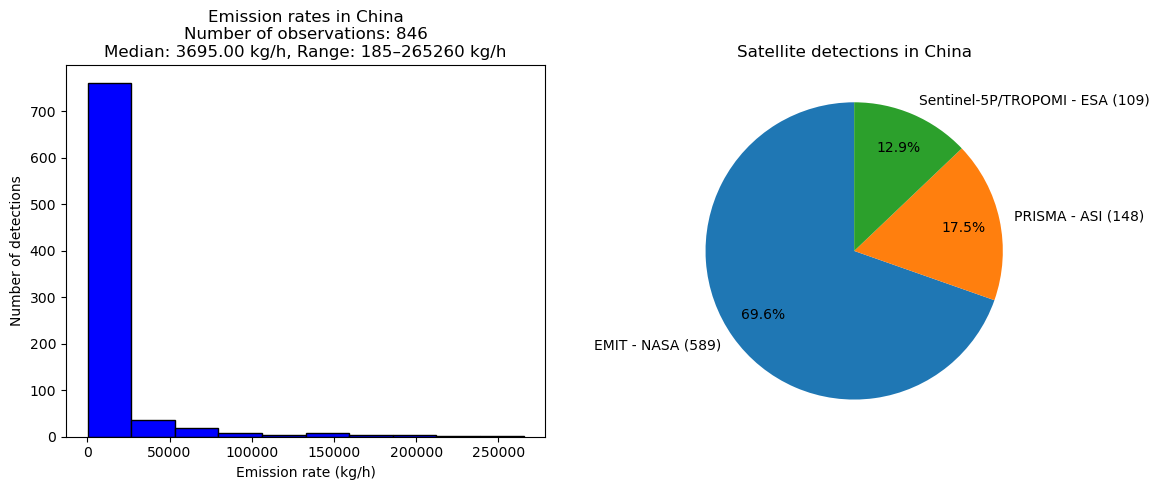

In [11]:
# this is just some plotting stuff 
print(merged_df['sensor'].unique())

# select a contry to plot
country='China'

country_counts = merged_df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

country_emissions = merged_df[merged_df['country'] == country]['emission rate (kg/h)']

min_val = country_emissions.min()
max_val = country_emissions.max()
median_val = country_emissions.median()
num_obs = len(country_emissions)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))  
ax1.hist(country_emissions, bins=10, color='blue', edgecolor='black')

ax1.set_title(
    f'Emission rates in {country}\nNumber of observations: {num_obs}\nMedian: {median_val:.2f} kg/h, Range: {min_val:.0f}–{max_val:.0f} kg/h'
)

ax1.set_xlabel('Emission rate (kg/h)')
ax1.set_ylabel('Number of detections')


country_data = merged_df[merged_df['country'] == country]
sensor_counts = country_data['sensor'].value_counts()
labels = [f'{sensor} ({count})' for sensor, count in sensor_counts.items()]


ax2.pie(
    sensor_counts,
    labels=labels,
    startangle=90,
    autopct='%1.1f%%',
    labeldistance=1.1,     
    pctdistance=0.75       
)
ax2.set_title(f'Satellite detections in {country}')


plt.tight_layout()
plt.show()
